In [1]:
from gurobi import *
import numpy as np
import pandas as pd
from scipy.spatial import distance
from itertools import chain, combinations
import matplotlib.pyplot as plt

# PDSTSP


In [2]:
class Data:
    def __init__(self):
        self.customerNum = 0 
        self.nodeNum     = 0 
        self.droneNum    = 2
        self.cities      = []
        self.cor_X       = [] 
        self.cor_Y       = [] 
        self.serviceTime = [] 
        self.disMatrix   = [[]]
        self.dt          = None
        self.i_pot = None
        self.cus_can_served_by_drone = None
        self.drone_distances = None
        self.truck_distances = None
        
      
        

    def readData(self, path):
        self.dt = pd.read_csv(path, header = None).to_numpy()[:-1]
        self.customerNum = len(self.dt)
        self.i_pot = self.dt[0, 1:3]
        self.nodeNum = self.customerNum + 2 
        self.cor_X = [self.dt[i, 1:3][0] for i in range(len(self.dt))]
        self.cor_Y = [self.dt[i, 1:3][1] for i in range(len(self.dt))]
        self.cities = [self.dt[i, 0] for i in range(len(self.dt))]
        
        self.cus_can_served_by_drone = [i for i in range(len(self.dt)) if self.dt[i, 3] == 0]
        
        self.drone_distances = [distance.euclidean((self.dt[i, 1:3]), self.i_pot)
                                if self.dt[i, 3] == 0 else float('inf')
                                for i in range(len(self.dt))]
        self.truck_distances = [[distance.cityblock(self.dt[i, 1:3], self.dt[j, 1:3])
                                 for i in range(len(self.dt))] for j in range(len(self.dt))]
    
    

        
       


In [3]:
data = Data()

data.readData("20140813T112010.csv")
print(data.dt)

print(data.customerNum)

[[ 0.   0.   0.   0.4]
 [ 1.   1.7  3.9  0. ]
 [ 2.   3.4  0.1  0. ]
 [ 3.   1.2  5.2  1. ]
 [ 4.   9.3  3.4  0. ]
 [ 5.   2.9  1.9  0. ]
 [ 6.   0.2  5.1  0. ]
 [ 7.   5.7  0.1  0. ]
 [ 8.   1.3 10.8  0. ]
 [ 9.   1.4  0.8  0. ]]
10


In [4]:
print(data.dt[1, 1:3])

[1.7 3.9]


In [5]:
print(data.cities)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


In [6]:
print(data.truck_distances)

[[0.0, 5.6, 3.5, 6.4, 12.700000000000001, 4.8, 5.3, 5.8, 12.100000000000001, 2.2], [5.6, 0.0, 5.5, 1.8000000000000003, 8.100000000000001, 3.2, 2.6999999999999997, 7.8, 7.300000000000001, 3.3999999999999995], [3.5, 5.5, 0.0, 7.300000000000001, 9.2, 2.3, 8.2, 2.3000000000000003, 12.8, 2.7], [6.4, 1.8000000000000003, 7.300000000000001, 0.0, 9.900000000000002, 5.0, 1.1000000000000005, 9.600000000000001, 5.700000000000001, 4.6000000000000005], [12.700000000000001, 8.100000000000001, 9.2, 9.900000000000002, 0.0, 7.9, 10.8, 6.9, 15.4, 10.5], [4.8, 3.2, 2.3, 5.0, 7.9, 0.0, 5.8999999999999995, 4.6, 10.5, 2.5999999999999996], [5.3, 2.6999999999999997, 8.2, 1.1000000000000005, 10.8, 5.8999999999999995, 0.0, 10.5, 6.800000000000001, 5.5], [5.8, 7.8, 2.3000000000000003, 9.600000000000001, 6.9, 4.6, 10.5, 0.0, 15.100000000000001, 5.000000000000001], [12.100000000000001, 7.300000000000001, 12.8, 5.700000000000001, 15.4, 10.5, 6.800000000000001, 15.100000000000001, 0.0, 10.1], [2.2, 3.3999999999999995

In [7]:
print(data.drone_distances)

[inf, 4.254409477236529, 3.4014702703389896, inf, 9.902019995940224, 3.4669871646719432, 5.103920062069938, 5.7008771254956905, 10.87795936745491, 1.6124515496597098]


In [8]:
model = Model("PDSTSP")

Academic license - for non-commercial use only - expires 2021-07-04
Using license file /home/quanghuy205/gurobi.lic


In [9]:
#SET
N = [i for i in range (1, data.customerNum)]
G = [0] + N
M = [m for m in range(data.droneNum)]

N_d = data.cus_can_served_by_drone
N_t = [i for i in N if i not in N_d]
A = [(i,j) for i in G for j in G if i != j]
C_truck = {(i,j): data.truck_distances[i][j] for i,j in A}
C_drone = data.drone_distances

#Decision variables
# z_i = 0: if cus i is visited by vehicle, = 1 if visited by drones
# x_ij if (i->j) in vehicle tour
# # y_im = 1 if cus i assigned to drone m ()
z = [i for i in G]
x = [[[] for i in G] for j in G]  
y = [[[]for i in G] for m in M] 


In [10]:
#Obj function
#completion time
T = model.addVar(0, GRB.INFINITY, 1.0, GRB.CONTINUOUS, "traveltime" )
expr = LinExpr(0)
expr.addTerms(1.0, T)
model.setObjective(expr, GRB.MINIMIZE)
expr.clear()

In [11]:
#2
expr = LinExpr(0)
for i in G:
    for j in G:
        if i != j:
            x[i][j] = model.addVar(0.0, 1.0, 0.0, GRB.BINARY, name="x%d,%d" % (i, j))
        
            expr.addTerms(data.truck_distances[i][j], x[i][j])
        else:
            x[i][i] = model.addVar(0.0, 0.0, 0.0, GRB.BINARY, name="x%d,%d" % (i, j))
            
model.update()
print(expr)
model.addConstr(T >= expr, "truckTime")

expr.clear()


<gurobi.LinExpr: 5.6 x0,1 + 3.5 x0,2 + 6.4 x0,3 + 12.700000000000001 x0,4 + 4.8 x0,5 + 5.3 x0,6 + 5.8 x0,7 + 12.100000000000001 x0,8 + 2.2 x0,9 + 5.6 x1,0 + 5.5 x1,2 + 1.8000000000000003 x1,3 + 8.100000000000001 x1,4 + 3.2 x1,5 + 2.6999999999999997 x1,6 + 7.8 x1,7 + 7.300000000000001 x1,8 + 3.3999999999999995 x1,9 + 3.5 x2,0 + 5.5 x2,1 + 7.300000000000001 x2,3 + 9.2 x2,4 + 2.3 x2,5 + 8.2 x2,6 + 2.3000000000000003 x2,7 + 12.8 x2,8 + 2.7 x2,9 + 6.4 x3,0 + 1.8000000000000003 x3,1 + 7.300000000000001 x3,2 + 9.900000000000002 x3,4 + 5.0 x3,5 + 1.1000000000000005 x3,6 + 9.600000000000001 x3,7 + 5.700000000000001 x3,8 + 4.6000000000000005 x3,9 + 12.700000000000001 x4,0 + 8.100000000000001 x4,1 + 9.2 x4,2 + 9.900000000000002 x4,3 + 7.9 x4,5 + 10.8 x4,6 + 6.9 x4,7 + 15.4 x4,8 + 10.5 x4,9 + 4.8 x5,0 + 3.2 x5,1 + 2.3 x5,2 + 5.0 x5,3 + 7.9 x5,4 + 5.8999999999999995 x5,6 + 4.6 x5,7 + 10.5 x5,8 + 2.5999999999999996 x5,9 + 5.3 x6,0 + 2.6999999999999997 x6,1 + 8.2 x6,2 + 1.1000000000000005 x6,3 + 10.8

In [12]:
#3
for m in M:
    expr = LinExpr(0)
    for i in N:
        if i in N_d: 
            y[m][i] = model.addVar(0.0, 1.0, 0.0, GRB.BINARY, name="y%d,%d" % (m, i) )
            expr.addTerms(data.drone_distances[i], y[m][i])
    model.update()
    print(expr)
    model.addConstr(T >= expr, "dronetime")
    expr.clear()
    



<gurobi.LinExpr: 4.254409477236529 y0,1 + 3.4014702703389896 y0,2 + 9.902019995940224 y0,4 + 3.4669871646719432 y0,5 + 5.103920062069938 y0,6 + 5.7008771254956905 y0,7 + 10.87795936745491 y0,8 + 1.6124515496597098 y0,9>
<gurobi.LinExpr: 4.254409477236529 y1,1 + 3.4014702703389896 y1,2 + 9.902019995940224 y1,4 + 3.4669871646719432 y1,5 + 5.103920062069938 y1,6 + 5.7008771254956905 y1,7 + 10.87795936745491 y1,8 + 1.6124515496597098 y1,9>


In [13]:
#4
for i in N:
    z[i] = model.addVar(0.0, 1.0, 0.0, GRB.BINARY, name = "z%d" % (i))


for i in N_t:
    expr = LinExpr(0)
    expr.addTerms(1.0, z[i])
    model.addConstr(expr == 1)
    expr.clear()


In [14]:
#5

for i in N:
    expr1 = LinExpr(0)
    expr2 = LinExpr(0)
    
    for j in G:
        expr1.addTerms(1.0, x[i][j])
        
    expr2.addTerms(1.0, z[i])
    
    model.addConstr(expr1 == expr2)
    expr1.clear()
    expr2.clear()

In [15]:
#6

for i in N_d:
    expr1 = LinExpr(0)
    expr2 = LinExpr(0)
    expr2.addTerms(1.0, z[i])
    
    for m in M:
        expr1.addTerms(1.0, y[m][i])
        
    model.addConstr(expr1 == 1 - expr2)
    
    expr1.clear()
    expr2.clear()

        
    

In [16]:
#8
for i in N:
    expr1 = LinExpr(0) 
    expr2 = LinExpr(0) 
    
    for k in G:
        
        expr1.addTerms(1, x[k][i]) 
                
    for j in G:
   
        expr2.addTerms(1, x[i][j]) 
               
    model.addConstr(expr1 == expr2) 
    expr1.clear() 
    expr2.clear() 

In [17]:
#7
expr = LinExpr(0)
for j in N:
    expr.addTerms(1.0, x[0][j])
    
model.addConstr(expr <= 1)
expr.clear()        
            

In [18]:
#get all subtours
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

S = list(powerset(range(1, len(data.cities))))
# The first element of the list is the empty set and the last element is the full set, hence we remove them.
S = S[1:(len(S) - 1)]

print(len(S))
import sys
print(sys.getsizeof(S)/1024/1024," GB")
print(S)

510
0.00394439697265625  GB
[(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 2, 6), (1, 2, 7), (1, 2, 8), (1, 2, 9), (1, 3, 4), (1, 3, 5), (1, 3, 6), (1, 3, 7), (1, 3, 8), (1, 3, 9), (1, 4, 5), (1, 4, 6), (1, 4, 7), (1, 4, 8), (1, 4, 9), (1, 5, 6), (1, 5, 7), (1, 5, 8), (1, 5, 9), (1, 6, 7), (1, 6, 8), (1, 6, 9), (1, 7, 8), (1, 7, 9), (1, 8, 9), (2, 3, 4), (2, 3, 5), (2, 3, 6), (2, 3, 7), (2, 3, 8), (2, 3, 9), (2, 4, 5), (2, 4, 6), (2, 4, 7), (2, 4, 8), (2, 4, 9), (2, 5, 6), (2, 5, 7), (2, 5, 8), (2, 5, 9), (2, 6, 7), (2, 6, 8), (2, 6, 9), (2, 7, 8), (2, 7, 9), (2, 8, 9), (3, 4, 5), (3, 4, 6), (3, 4, 7), (3, 4, 8), (3, 4, 9), (3, 5, 6), (3, 5, 7), (3, 5, 8), (3

In [19]:
for s in S:
    expr1 = LinExpr(0)
    expr2 = LinExpr(0)
    
    for i in s:
        for j in G:
            if j not in s:
                expr1.addTerms(1.0, x[i][j])
                
  
        expr2.addTerms(1.0, z[i])
    model.update()
    print(expr1)
    print(expr2)
    model.addConstr(expr1 >= expr2 + 1 - len(s))
    expr1.clear()
    expr2.clear()

<gurobi.LinExpr: x1,0 + x1,2 + x1,3 + x1,4 + x1,5 + x1,6 + x1,7 + x1,8 + x1,9>
<gurobi.LinExpr: z1>
<gurobi.LinExpr: x2,0 + x2,1 + x2,3 + x2,4 + x2,5 + x2,6 + x2,7 + x2,8 + x2,9>
<gurobi.LinExpr: z2>
<gurobi.LinExpr: x3,0 + x3,1 + x3,2 + x3,4 + x3,5 + x3,6 + x3,7 + x3,8 + x3,9>
<gurobi.LinExpr: z3>
<gurobi.LinExpr: x4,0 + x4,1 + x4,2 + x4,3 + x4,5 + x4,6 + x4,7 + x4,8 + x4,9>
<gurobi.LinExpr: z4>
<gurobi.LinExpr: x5,0 + x5,1 + x5,2 + x5,3 + x5,4 + x5,6 + x5,7 + x5,8 + x5,9>
<gurobi.LinExpr: z5>
<gurobi.LinExpr: x6,0 + x6,1 + x6,2 + x6,3 + x6,4 + x6,5 + x6,7 + x6,8 + x6,9>
<gurobi.LinExpr: z6>
<gurobi.LinExpr: x7,0 + x7,1 + x7,2 + x7,3 + x7,4 + x7,5 + x7,6 + x7,8 + x7,9>
<gurobi.LinExpr: z7>
<gurobi.LinExpr: x8,0 + x8,1 + x8,2 + x8,3 + x8,4 + x8,5 + x8,6 + x8,7 + x8,9>
<gurobi.LinExpr: z8>
<gurobi.LinExpr: x9,0 + x9,1 + x9,2 + x9,3 + x9,4 + x9,5 + x9,6 + x9,7 + x9,8>
<gurobi.LinExpr: z9>
<gurobi.LinExpr: x1,0 + x1,3 + x1,4 + x1,5 + x1,6 + x1,7 + x1,8 + x1,9 + x2,0 + x2,3 + x2,4 + x2,5 +

<gurobi.LinExpr: x1,0 + x1,5 + x1,7 + x1,9 + x2,0 + x2,5 + x2,7 + x2,9 + x3,0 + x3,5 + x3,7 + x3,9 + x4,0 + x4,5 + x4,7 + x4,9 + x6,0 + x6,5 + x6,7 + x6,9 + x8,0 + x8,5 + x8,7 + x8,9>
<gurobi.LinExpr: z1 + z2 + z3 + z4 + z6 + z8>
<gurobi.LinExpr: x1,0 + x1,5 + x1,7 + x1,8 + x2,0 + x2,5 + x2,7 + x2,8 + x3,0 + x3,5 + x3,7 + x3,8 + x4,0 + x4,5 + x4,7 + x4,8 + x6,0 + x6,5 + x6,7 + x6,8 + x9,0 + x9,5 + x9,7 + x9,8>
<gurobi.LinExpr: z1 + z2 + z3 + z4 + z6 + z9>
<gurobi.LinExpr: x1,0 + x1,5 + x1,6 + x1,9 + x2,0 + x2,5 + x2,6 + x2,9 + x3,0 + x3,5 + x3,6 + x3,9 + x4,0 + x4,5 + x4,6 + x4,9 + x7,0 + x7,5 + x7,6 + x7,9 + x8,0 + x8,5 + x8,6 + x8,9>
<gurobi.LinExpr: z1 + z2 + z3 + z4 + z7 + z8>
<gurobi.LinExpr: x1,0 + x1,5 + x1,6 + x1,8 + x2,0 + x2,5 + x2,6 + x2,8 + x3,0 + x3,5 + x3,6 + x3,8 + x4,0 + x4,5 + x4,6 + x4,8 + x7,0 + x7,5 + x7,6 + x7,8 + x9,0 + x9,5 + x9,6 + x9,8>
<gurobi.LinExpr: z1 + z2 + z3 + z4 + z7 + z9>
<gurobi.LinExpr: x1,0 + x1,5 + x1,6 + x1,7 + x2,0 + x2,5 + x2,6 + x2,7 + x3,0 + 

<gurobi.LinExpr: x1,0 + x1,5 + x1,9 + x2,0 + x2,5 + x2,9 + x3,0 + x3,5 + x3,9 + x4,0 + x4,5 + x4,9 + x6,0 + x6,5 + x6,9 + x7,0 + x7,5 + x7,9 + x8,0 + x8,5 + x8,9>
<gurobi.LinExpr: z1 + z2 + z3 + z4 + z6 + z7 + z8>
<gurobi.LinExpr: x1,0 + x1,5 + x1,8 + x2,0 + x2,5 + x2,8 + x3,0 + x3,5 + x3,8 + x4,0 + x4,5 + x4,8 + x6,0 + x6,5 + x6,8 + x7,0 + x7,5 + x7,8 + x9,0 + x9,5 + x9,8>
<gurobi.LinExpr: z1 + z2 + z3 + z4 + z6 + z7 + z9>
<gurobi.LinExpr: x1,0 + x1,5 + x1,7 + x2,0 + x2,5 + x2,7 + x3,0 + x3,5 + x3,7 + x4,0 + x4,5 + x4,7 + x6,0 + x6,5 + x6,7 + x8,0 + x8,5 + x8,7 + x9,0 + x9,5 + x9,7>
<gurobi.LinExpr: z1 + z2 + z3 + z4 + z6 + z8 + z9>
<gurobi.LinExpr: x1,0 + x1,5 + x1,6 + x2,0 + x2,5 + x2,6 + x3,0 + x3,5 + x3,6 + x4,0 + x4,5 + x4,6 + x7,0 + x7,5 + x7,6 + x8,0 + x8,5 + x8,6 + x9,0 + x9,5 + x9,6>
<gurobi.LinExpr: z1 + z2 + z3 + z4 + z7 + z8 + z9>
<gurobi.LinExpr: x1,0 + x1,4 + x1,9 + x2,0 + x2,4 + x2,9 + x3,0 + x3,4 + x3,9 + x5,0 + x5,4 + x5,9 + x6,0 + x6,4 + x6,9 + x7,0 + x7,4 + x7,9 + x

In [20]:
model.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 541 rows, 126 columns and 14210 nonzeros
Model fingerprint: 0x0661a54f
Variable types: 1 continuous, 125 integer (125 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
Found heuristic solution: objective 40.0656853
Presolve removed 10 rows and 11 columns
Presolve time: 0.01s
Presolved: 531 rows, 115 columns, 13837 nonzeros
Variable types: 1 continuous, 114 integer (114 binary)

Root relaxation: objective 1.268743e+01, 54 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   12.68743    0   22   40.06569   12.68743  68.3%     -    0s
H    0     0                      27.4000000   1

In [21]:
model.printAttr('X')



    Variable            X 
-------------------------
  traveltime         16.2 
        x0,6            1 
        x1,5            1 
        x3,1            1 
        x5,9            1 
        x6,3            1 
        x9,0            1 
        y0,2            1 
        y0,8            1 
        y1,4            1 
        y1,7            1 
          z1            1 
          z3            1 
          z5            1 
          z6            1 
          z9            1 


In [22]:
model.getVars()

[<gurobi.Var traveltime (value 16.199999999999996)>,
 <gurobi.Var x0,0 (value 0.0)>,
 <gurobi.Var x0,1 (value -0.0)>,
 <gurobi.Var x0,2 (value -0.0)>,
 <gurobi.Var x0,3 (value -0.0)>,
 <gurobi.Var x0,4 (value -0.0)>,
 <gurobi.Var x0,5 (value -0.0)>,
 <gurobi.Var x0,6 (value 1.0)>,
 <gurobi.Var x0,7 (value -0.0)>,
 <gurobi.Var x0,8 (value -0.0)>,
 <gurobi.Var x0,9 (value -0.0)>,
 <gurobi.Var x1,0 (value -0.0)>,
 <gurobi.Var x1,1 (value 0.0)>,
 <gurobi.Var x1,2 (value -0.0)>,
 <gurobi.Var x1,3 (value -0.0)>,
 <gurobi.Var x1,4 (value -0.0)>,
 <gurobi.Var x1,5 (value 1.0)>,
 <gurobi.Var x1,6 (value -0.0)>,
 <gurobi.Var x1,7 (value -0.0)>,
 <gurobi.Var x1,8 (value -0.0)>,
 <gurobi.Var x1,9 (value -0.0)>,
 <gurobi.Var x2,0 (value -0.0)>,
 <gurobi.Var x2,1 (value -0.0)>,
 <gurobi.Var x2,2 (value 0.0)>,
 <gurobi.Var x2,3 (value -0.0)>,
 <gurobi.Var x2,4 (value -0.0)>,
 <gurobi.Var x2,5 (value -0.0)>,
 <gurobi.Var x2,6 (value -0.0)>,
 <gurobi.Var x2,7 (value -0.0)>,
 <gurobi.Var x2,8 (value -0.

In [23]:
truck_tours = [(i,j) for i in G for j in G if x[i][j].x > 0.99]

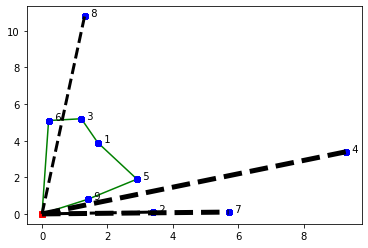

In [24]:
plt.plot(data.i_pot[0], data.i_pot[1], c='r', marker='s')
# plt.scatter(xc[1:], yc[1:], c='b')
for i in range(1,data.customerNum):
    plt.scatter(data.cor_X, data.cor_Y, c='b')
    plt.annotate(str("  ") + str(int(data.cities[i])), (data.cor_X[i], data.cor_Y[i]))
    
for i, j in truck_tours:
    plt.plot([data.cor_X[i], data.cor_X[j]], [data.cor_Y[i], data.cor_Y[j]], c='g', zorder=0)
    
    
default_width = 1

for m in M:
    default_width+= 2
    for i in N_d:
        if y[m][i].x > 0.99:
            plt.plot([data.i_pot[0],data.cor_X[i]], [data.i_pot[1], data.cor_Y[i]], color='black', linestyle='dashed', linewidth = default_width)